# 1. Introduction

The first notebook downloads all necessary data and metadata for the tutorial. A similar approach may be reproduced to analyze any seismic data set of your choice.

Note that this tutorial uses `pathlib.Path` objects to handle conveniently file paths. For more information you read the [official pathlib documentation](https://docs.python.org/3/library/pathlib.html). Also note that the velocity model is stored as an `hdf5` file, which is a binary file format that we manipulate with the `h5py` library. If you are not familiar with `hdf5` files, you can read the [h5py documentation](https://docs.h5py.org/en/stable/). In general, the velocity model may be written in any format.

In [31]:
from pathlib import Path

import h5py as h5
import numpy as np
import obspy

import covseisnet as csn

## Read seismic data

The continuous seismic data are stored in a miniseed file at `../data/`. We read the data with the `covseisnet.read` function, which instanciates a `covseisnet.NetworkStream` class. This class is closely related to the `obspy.Stream` class.

In [32]:
# Set the download path for the data
filepath = Path("../data/undervolc.mseed")
filepath.parent.mkdir(exist_ok=True)

# Check stream
stream = csn.read(filepath)
print(stream)

15 Trace(s) in NetworkStream (synced):
YA.UV01.00.HHZ | 2010-10-14T09:00:00.000000Z - 2010-10-14T15:59:59.950000Z | 20.0 Hz, 504000 samples
YA.UV02.00.HHZ | 2010-10-14T09:00:00.000000Z - 2010-10-14T15:59:59.950000Z | 20.0 Hz, 504000 samples
YA.UV03.00.HHZ | 2010-10-14T09:00:00.000000Z - 2010-10-14T15:59:59.950000Z | 20.0 Hz, 504000 samples
YA.UV04.00.HHZ | 2010-10-14T09:00:00.000000Z - 2010-10-14T15:59:59.950000Z | 20.0 Hz, 504000 samples
YA.UV05.00.HHZ | 2010-10-14T09:00:00.000000Z - 2010-10-14T15:59:59.950000Z | 20.0 Hz, 504000 samples
YA.UV06.00.HHZ | 2010-10-14T09:00:00.000000Z - 2010-10-14T15:59:59.950000Z | 20.0 Hz, 504000 samples
YA.UV07.00.HHZ | 2010-10-14T09:00:00.000000Z - 2010-10-14T15:59:59.950000Z | 20.0 Hz, 504000 samples
YA.UV08.00.HHZ | 2010-10-14T09:00:00.000000Z - 2010-10-14T15:59:59.950000Z | 20.0 Hz, 504000 samples
YA.UV09.00.HHZ | 2010-10-14T09:00:00.000000Z - 2010-10-14T15:59:59.950000Z | 20.0 Hz, 504000 samples
YA.UV10.00.HHZ | 2010-10-14T09:00:00.000000Z - 2010-

## Read metadata (data inventory)

Station metadata are stored in an xml file at `../data/`. We read this file with `obspy.read_inventory`, which returns an `inventory` object is an ObsPy object that comes with several useful methods, including a plotting method. If your Python environment includes `cartopy`, `inventory.plot` uses it to draw the map.

In [33]:
# Read the inventory
inventory = obspy.read_inventory("../data/undervolc.xml")

Text(0.5, 1.0, 'Map of seismic stations near Piton de la Fournaise')

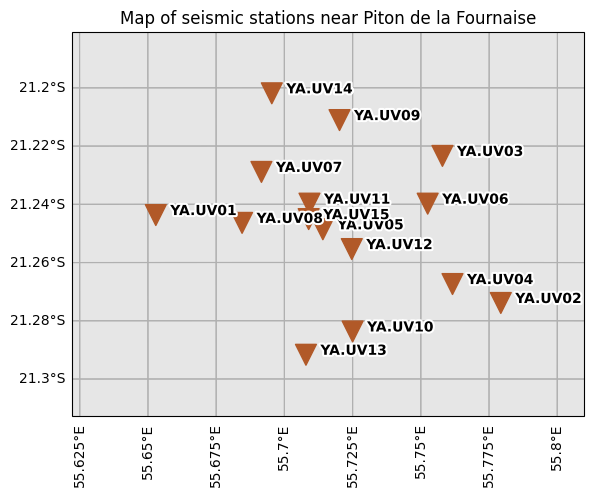

In [34]:
# Plot the inventory
fig = inventory.plot(projection="local", show=False)

# Extract axes for custom labelling
ax = fig.axes[0]
gridlines = ax.gridlines(draw_labels=True)
gridlines.top_labels = False
gridlines.right_labels = False
ax.set_title("Map of seismic stations near Piton de la Fournaise")

## Read the velocity model of the Piton de la Fournaise volcano

We use the 3D velocity model of the Piton de la Fournaise volcano (Mordret et al. 2014), available in the supplementary material. The model has to be prescribed onto a regular 3D grid in longitude/latitude/depth. The model can be displayed with the `grid3d` function of the `covseisnet.plot` module. 

> Mordret, A., Rivet, D., Landès, M., & Shapiro, N. M. (2015). Three‐dimensional shear velocity anisotropic model of Piton de la Fournaise Volcano (La Réunion Island) from ambient seismic noise. Journal of Geophysical Research: Solid Earth, 120(1), 406-427.

Text(0.5, 0.98, 'S-wave velocity model in the original grid')

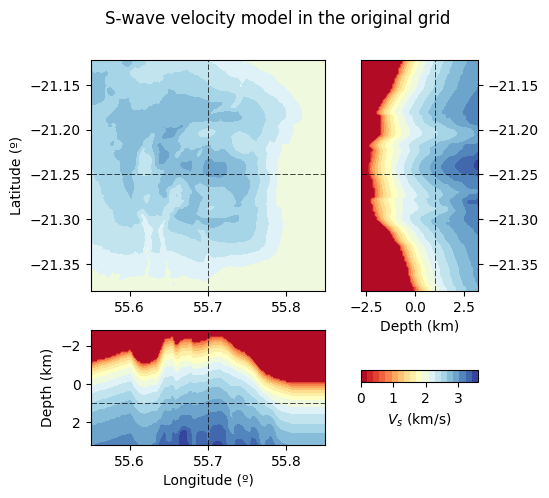

In [37]:
# Read the model
filepath_model = Path("../data/undervolc_vs_mordret_2015.h5").absolute()
velocity_field_name = "Vs"

# The h5 file contains the velocity model in a 3D grid with the following
# dimensions in order: longitude, latitude, depth. The depth and velocity are
# in meters and meters per second, respectively.
with h5.File(filepath_model, "r") as velocity_model:

    # Coordinates
    lon = np.array(velocity_model["longitude"])
    lat = np.array(velocity_model["latitude"])
    depth = np.array(velocity_model["depth"])

    # Velocity
    velocity = np.array(velocity_model[velocity_field_name])

# Get extent
model = csn.velocity.model_from_grid(lon, lat, depth, velocity)

# Plot the grid
fig, axes = csn.plot.grid3d(model, profile_coordinates=[55.7, -21.25, 1], cmap="RdYlBu", label="$V_s$ (km/s)")
fig.suptitle("S-wave velocity model in the original grid")

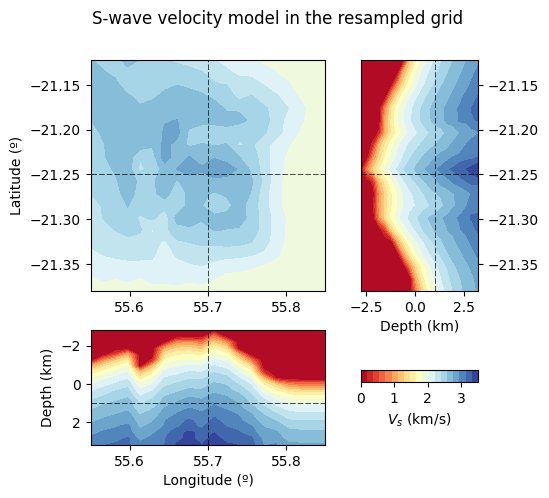

In [38]:
model_i = model.resample((20, 20, 20))

fig, ax = csn.plot.grid3d(
    model_i,
    profile_coordinates=[55.7, -21.25, 1],
    cmap="RdYlBu",
    label="$V_s$ (km/s)",
)

fig.suptitle("S-wave velocity model in the resampled grid")

csn.plot.plt.show()

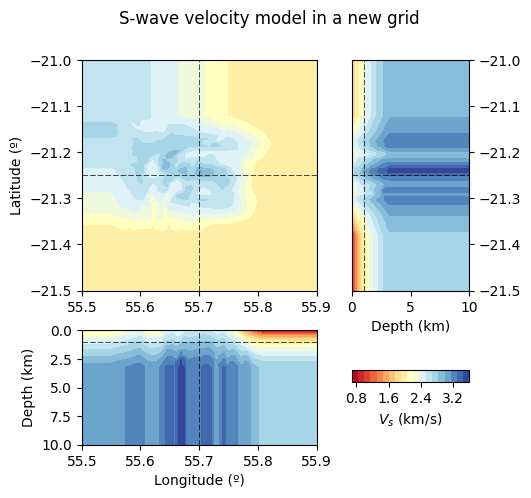

In [39]:
lons = np.linspace(55.5, 55.9, 100)
lats = np.linspace(-21.5, -21, 100)
depths = np.linspace(0, 10, 100)

model_i = model.interpolate(lons, lats, depths)

fig, ax = csn.plot.grid3d(
    model_i,
    profile_coordinates=[55.7, -21.25, 1],
    cmap="RdYlBu",
    label="$V_s$ (km/s)",
)
fig.suptitle("S-wave velocity model in a new grid")
csn.plot.plt.show()